In [1]:
import csv
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, CSV

In [2]:
sparql = SPARQLWrapper("https://stko-kwg.geog.ucsb.edu/graphdb/repositories/KWG")
sparql.setReturnFormat(CSV)
road_query = """PREFIX sf: <http://www.opengis.net/ont/sf#>
PREFIX kwgr: <http://stko-kwg.geog.ucsb.edu/lod/resource/>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX geosparql: <http://www.opengis.net/ont/geosparql#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
select ?sign ?wkt where { 
	?s rdf:type <http://stko-kwg.geog.ucsb.edu/lod/ontology/RoadSegment> .
    ?s rdfs:label ?road .
    ?s kwg-ont:hasRoadSign ?sign .
    ?s kwg-ont:sfWithin kwgr:Earth.North_America.United_States.USA.5.42_1 .
    ?s geo:hasGeometry ?geometry .
    ?geometry geosparql:asWKT ?wkt .
}"""
sparql.setQuery(road_query)
try:
    ret = sparql.query().convert()
    with open('roads.csv','wb') as file:
        file.write(ret)
except Exception as e:
    print(f"There was a problem retrieving the roads: {e}")

There was a problem retrieving the roads: [Errno 13] Permission denied: 'roads.csv'


In [3]:
hospital_query = """PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX kwgr: <http://stko-kwg.geog.ucsb.edu/lod/resource/>
PREFIX geosparql: <http://www.opengis.net/ont/geosparql#>
select ?hospital ?has_helipad ?name ?bed_count ?wkt where { 
	?hospital a kwg-ont:Hospital .
    ?hospital kwg-ont:helipadAvailability ?has_helipad .
    ?hospital kwg-ont:hospitalName ?name .
    ?hospital kwg-ont:noHospitalBeds ?bed_count .
    ?hospital geosparql:hasDefaultGeometry ?geom .
    ?geom geosparql:asWKT ?wkt .
    kwgr:Earth.North_America.United_States.USA.5.42_1 kwg-ont:sfContains ?s2Cell.
    ?hospital kwg-ont:sfWithin ?s2Cell .
}"""
sparql.setQuery(hospital_query)
try:
    res = sparql.query().convert()
    with open('hospitals.csv','wb') as file:
            file.write(res)
except Exception as e:
    print(f"There was a problem retrieving the hospitals: {e}")

In [5]:
line_strings = []
with open('roads.csv', newline='') as road_file:
    road_reader = csv.reader(road_file)
    next(road_reader) 
    for road in road_reader:
        road = road[0]
        line_strings.append(shapely.wkt.loads(str(road)))

hospital_locations = []
with open('hospitals.csv', newline='') as road_file:
    road_reader = csv.reader(road_file)
    next(road_reader) 
    for hospital_row in road_reader:
        hospital = hospital_row[4]
        hospital_locations.append(shapely.wkt.loads(str(hospital)))

        
santa_barbara_shape = gpd.read_file('work/rasters/tl_2019_06083_faces.shp')
road_data = gpd.GeoDataFrame(geometry=line_strings, crs='epsg:4326')
road_data = road_data.to_crs(santa_barbara_shape.crs)

hospital_data = gpd.GeoDataFrame(geometry=hospital_locations, crs='epsg:4326')

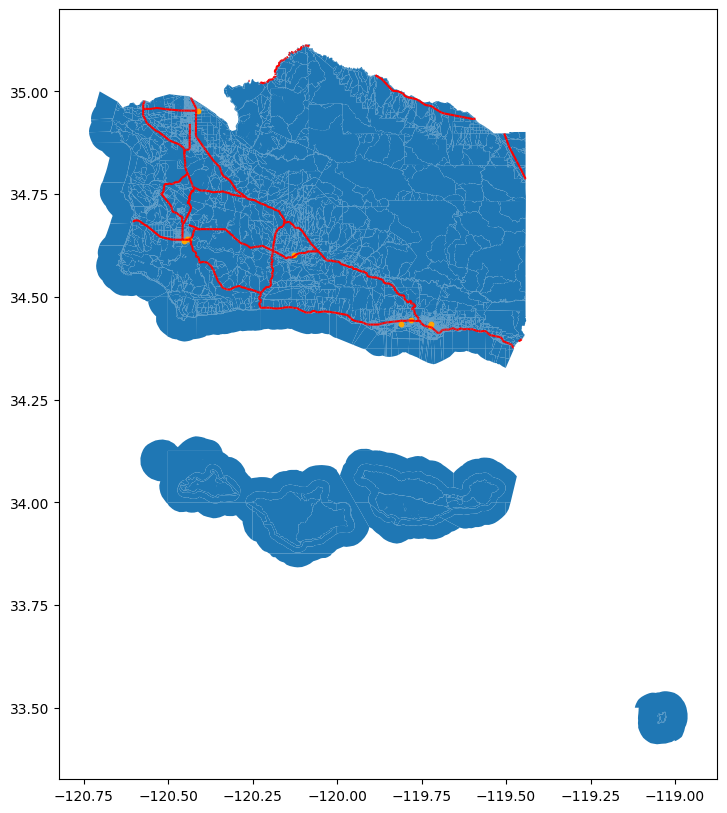

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
santa_barbara_shape.plot(ax=ax)
road_data.plot(ax=ax,  marker='o', color='red', markersize=10)
hospital_data.plot(ax=ax,  marker='o', color='orange', markersize=10)
plt.show()